In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../new_modules')
import ObsModels
import utils

import ChemotaxisModels as chem

import FSC as controller

from scipy.optimize import curve_fit
import numba as nb

In [3]:
import torch
import copy

# Proof-of-principle design for perfect adaptation

In [4]:
NSteps1 = 20000
NSteps2 = 20000
c0 = 0.2
c1 = c0*10
ttumble = 0.1
dt = 1e-3

tau_sub = 100

In [5]:
F = 2
M = 2
A = 2

In [6]:
cvalues = np.array([0.1, 1])
feature_array = np.array([np.ones(cvalues.size), cvalues])

In [7]:
psi_design = np.array([3, 1])

phi_design = np.zeros((F, M, M, A))

phi_design[0, 0] = np.array([[1, 1],
                             [-4, -4]])

phi_design[1, 0] = np.array([[-1.5, -1.95],
                             [1, 1]])

phi_design[0, 1] = np.array([[-2, -2],
                             [1, 1]])

phi_design[1, 1] = np.array([[-3, -1.5],
                             [-1, -1]])



zeta_design = np.zeros((F, M, A))

zeta_design[0] = np.array([[2., 0],
                           [1.75, 0]])

zeta_design[1] = np.array([[4.5, -0.5],
                           [0.42, -0.05]])

FSC_designed = controller.FSC("continuous", M = M, A = A, F = F, mode = "generation")
FSC_designed.load_parameters(phi_design, zeta_design, psi_design)

In [8]:
Ntraj_play = 10000
concentration_low = np.ones(NSteps1//tau_sub) * 0.1
concentration_high = np.ones(NSteps2//tau_sub) * 1
concentration = np.concatenate((concentration_low, concentration_high))

features_play = [np.array([np.ones(concentration.size), concentration])]*Ntraj_play

In [9]:
generated_tr = FSC_designed.generate_trajectories(features = features_play)

for i in range(len(generated_tr)):
    kkeys = list(generated_tr[i].keys())
    generated_tr[i]["actions"] = generated_tr[i]["actions"][NSteps1//2//tau_sub:]
    generated_tr[i]["memories"] = generated_tr[i]["memories"][NSteps1//2//tau_sub:]
    generated_tr[i]["features"] = generated_tr[i]["features"][:, NSteps1//2//tau_sub:]

In [10]:
TimePlay = np.linspace(0, (NSteps1 // 2 + NSteps2)*dt, (NSteps1 // 2 + NSteps2)//tau_sub)

actions_play = np.array([tr["actions"] for tr in generated_tr])
pr = np.mean(actions_play == 0, axis = 0)

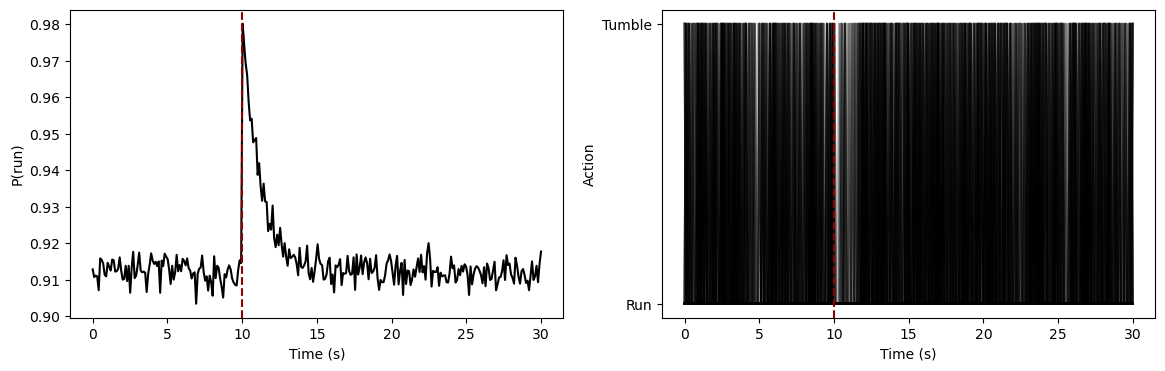

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(TimePlay, pr, c = 'k')
axs[0].axvline(NSteps1//2*dt, c = 'darkred', ls = '--')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("P(run)")

axs[1].plot(TimePlay, actions_play[:50].T, c = 'k', alpha = 0.3)
axs[1].axvline(NSteps1//2*dt, c = 'darkred', ls = '--')

axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Action")
axs[1].set_yticks([0, 1], labels = ["Run", "Tumble"])

plt.show()

/mnt/DAA0C4FEA0C4E1DD/Users/gnico/github/InferenceFSCs/notebooks/../new_modules/ContinuousObs/generation.py:406: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  m = transition_probs @ rho


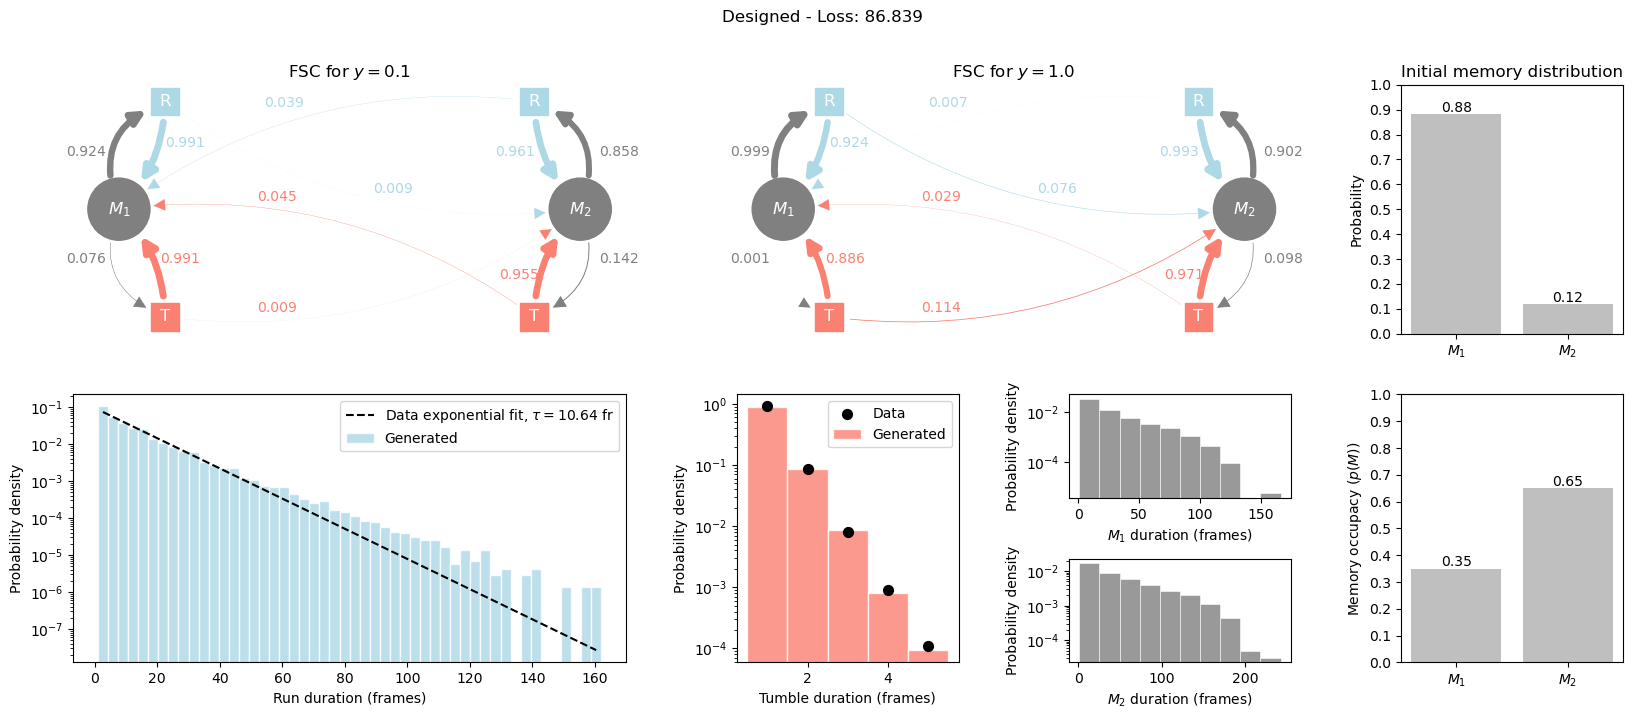

In [12]:
res = FSC_designed.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Designed", return_results = True)

In [13]:
pActEq_target, pMemEq_target, policy_target = FSC_designed.compute_eq_probability(feature_array)

In [14]:
pActEq_target

array([[0.9123977 , 0.0876023 ],
       [0.91222759, 0.08777241]])

# Training trajectories generation

In [15]:
NSteps1 = 10000
NSteps2 = 10000
c0 = 0.2
c1 = c0*10
ttumble = 0.1
dt = 1e-3

tau_sub = 100

In [16]:
F = 2
M = 2
A = 2

In [17]:
cvalues = np.array([0.1, 1])
feature_array = np.array([np.ones(cvalues.size), cvalues])

In [18]:
psi_design = np.array([3, 1])

phi_design = np.zeros((F, M, M, A))

phi_design[0, 0] = np.array([[1, 1],
                             [-4, -4]])

phi_design[1, 0] = np.array([[-1.5, -1.95],
                             [1, 1]])

phi_design[0, 1] = np.array([[-2, -2],
                             [1, 1]])

phi_design[1, 1] = np.array([[-3, -1.5],
                             [-1, -1]])



zeta_design = np.zeros((F, M, A))

zeta_design[0] = np.array([[2., 0],
                           [1.75, 0]])

zeta_design[1] = np.array([[4.5, -0.5],
                           [0.42, -0.05]])

FSC_designed = controller.FSC("continuous", M = M, A = A, F = F, mode = "generation")
FSC_designed.load_parameters(phi_design, zeta_design, psi_design)

In [19]:
Ntraj_play = 500
concentration_low = np.ones(NSteps1//tau_sub) * 0.1
concentration_high = np.ones(NSteps2//tau_sub) * 1
concentration = np.concatenate((concentration_low, concentration_high))

features_play = [np.array([np.ones(concentration.size), concentration])]*Ntraj_play

In [20]:
generated_tr = FSC_designed.generate_trajectories(features = features_play)

for i in range(len(generated_tr)):
    kkeys = list(generated_tr[i].keys())
    generated_tr[i]["actions"] = generated_tr[i]["actions"][NSteps1//2//tau_sub:]
    generated_tr[i]["memories"] = generated_tr[i]["memories"][NSteps1//2//tau_sub:]
    generated_tr[i]["features"] = generated_tr[i]["features"][:, NSteps1//2//tau_sub:]

In [21]:
TimePlay = np.linspace(0, (NSteps1 // 2 + NSteps2)*dt, (NSteps1 // 2 + NSteps2)//tau_sub)

actions_play = np.array([tr["actions"] for tr in generated_tr])
pr = np.mean(actions_play == 0, axis = 0)

In [22]:
(NSteps1 // 2 + NSteps2)*dt

15.0

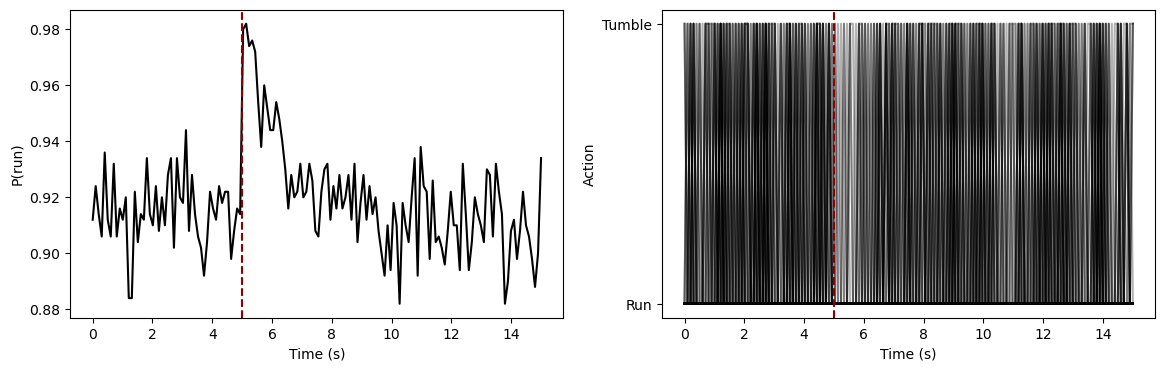

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(TimePlay, pr, c = 'k')
axs[0].axvline(NSteps1//2*dt, c = 'darkred', ls = '--')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("P(run)")

axs[1].plot(TimePlay, actions_play[:50].T, c = 'k', alpha = 0.3)
axs[1].axvline(NSteps1//2*dt, c = 'darkred', ls = '--')

axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Action")
axs[1].set_yticks([0, 1], labels = ["Run", "Tumble"])

plt.show()

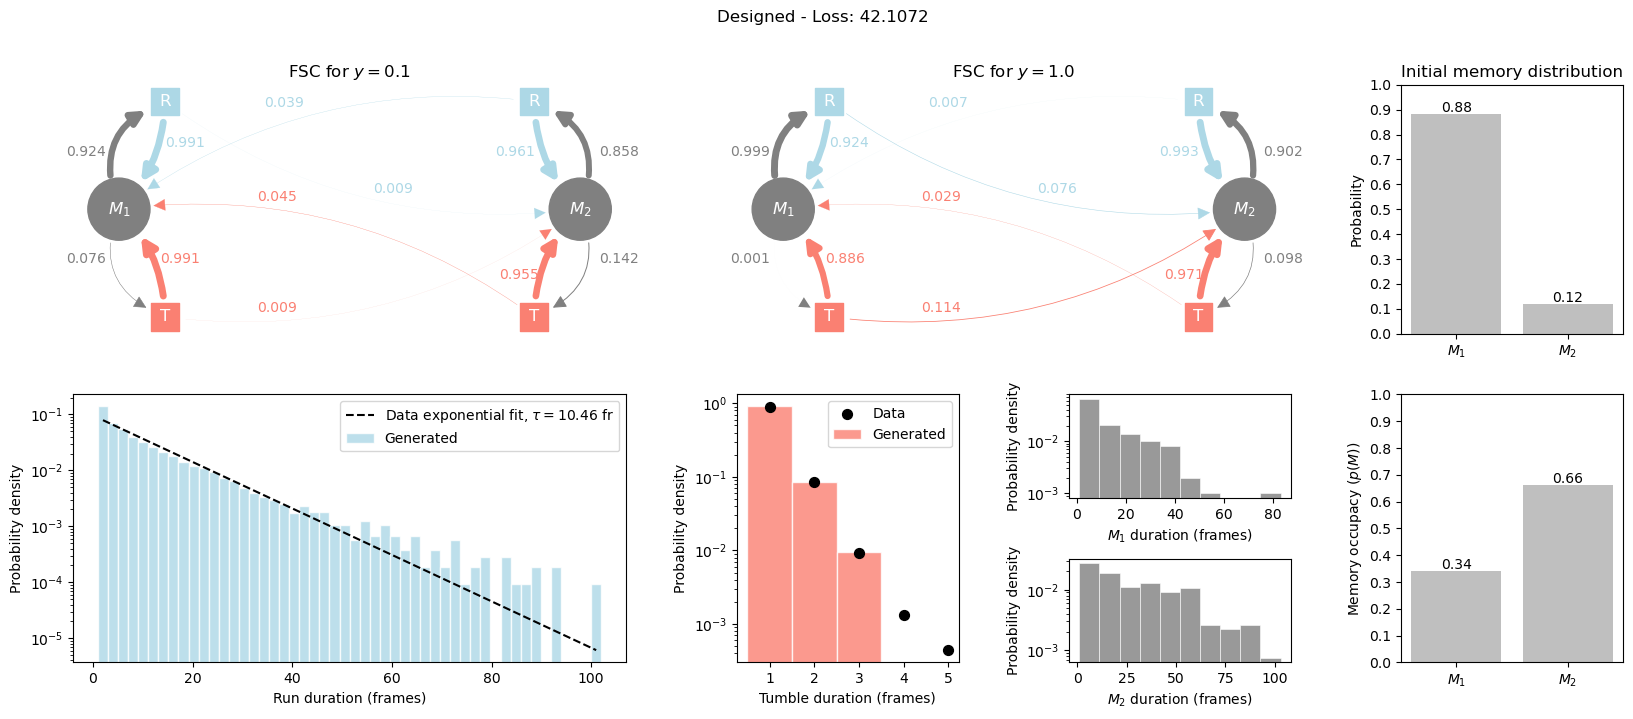

In [24]:
res = FSC_designed.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Designed", return_results = True)

# Train test

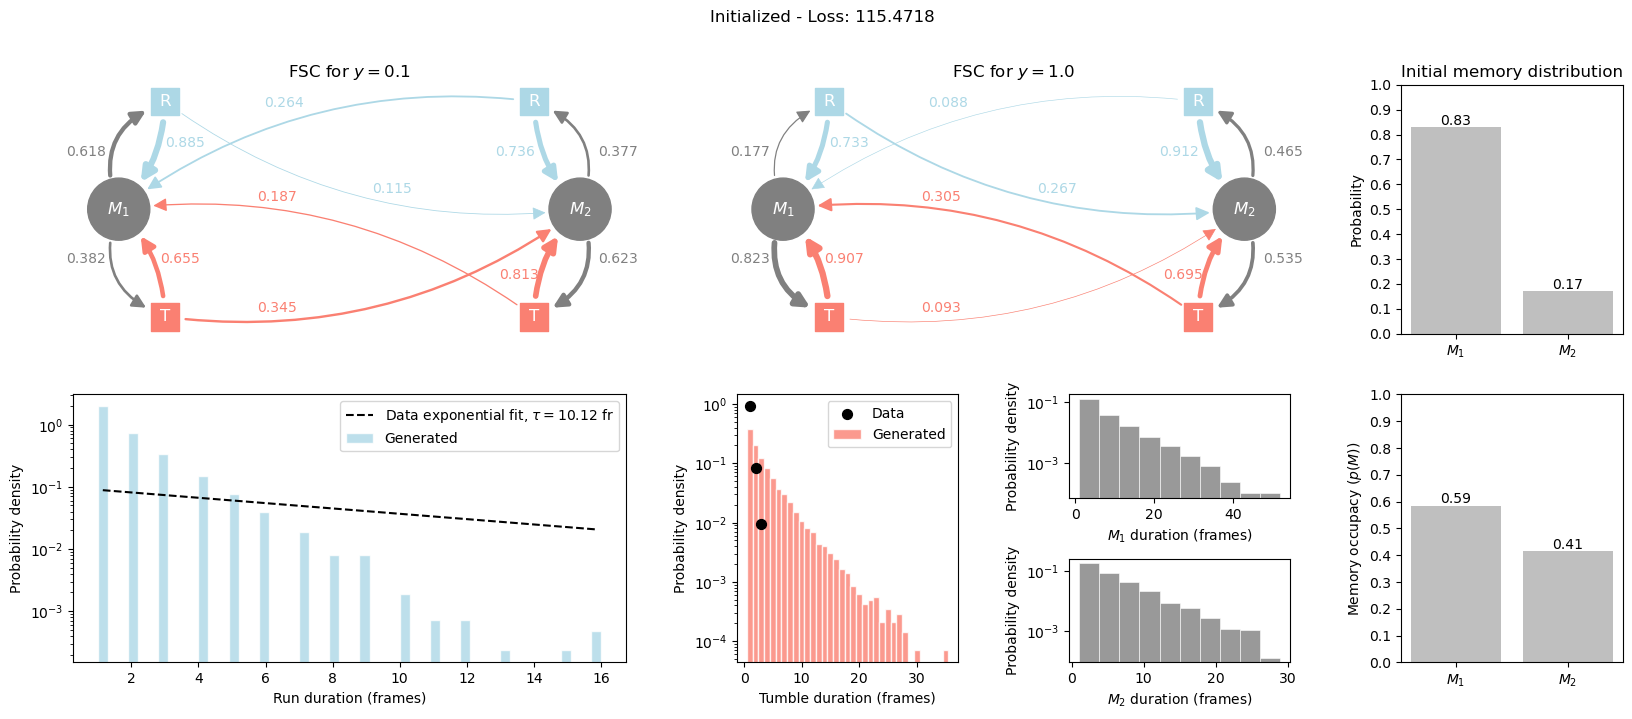

In [73]:
FSC_inferred = controller.FSC("continuous", M = M, A = A, F = F, mode = "generation", seed = 1)
FSC_inferred.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Initialized", return_results = False)

In [74]:
feature_array_all = np.array([np.ones(100), np.linspace(0, 1.5, 100)])

In [75]:
pActEq_designed, pMemEq_designed, policy_designed = FSC_designed.compute_eq_probability(feature_array_all)
pActEq_inferred, pMemEq_inferred, policy_inferred = FSC_inferred.compute_eq_probability(feature_array_all)

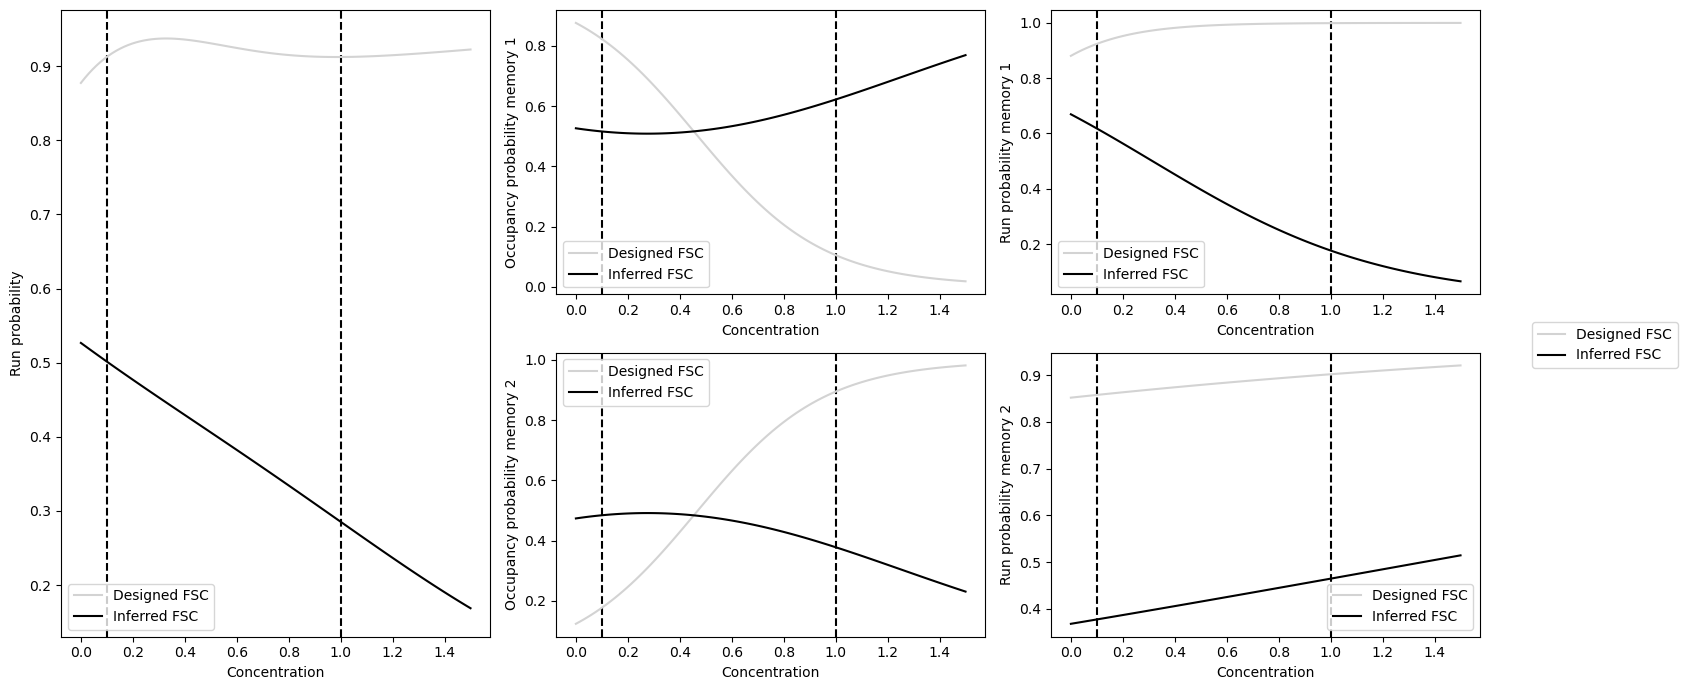

In [76]:
fig, axs = plt.subplot_mosaic([["run_prob", "pm1", "pi1"],
                               ["run_prob", "pm2", "pi2"]], figsize=(15, 7))

# Plot run probability
axs["run_prob"].plot(feature_array_all[1], pActEq_designed[:, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["run_prob"].plot(feature_array_all[1], pActEq_inferred[:, 0], label="Inferred FSC", c='black', alpha=1)
axs["run_prob"].set_xlabel("Concentration")
axs["run_prob"].set_ylabel("Run probability")
axs["run_prob"].legend()

# Plot pm1
axs["pm1"].plot(feature_array_all[1], pMemEq_designed[:, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pm1"].plot(feature_array_all[1], pMemEq_inferred[:, 0], label="Inferred FSC", c='black', alpha=1)
axs["pm1"].set_xlabel("Concentration")
axs["pm1"].set_ylabel("Occupancy probability memory 1")
axs["pm1"].legend()

# Plot pm2
axs["pm2"].plot(feature_array_all[1], pMemEq_designed[:, 1], label="Designed FSC", c='lightgrey', alpha=1)
axs["pm2"].plot(feature_array_all[1], pMemEq_inferred[:, 1], label="Inferred FSC", c='black', alpha=1)
axs["pm2"].set_xlabel("Concentration")
axs["pm2"].set_ylabel("Occupancy probability memory 2")
axs["pm2"].legend()

# Plot pi1
axs["pi1"].plot(feature_array_all[1], policy_designed[:, 0, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pi1"].plot(feature_array_all[1], policy_inferred[:, 0, 0], label="Inferred FSC", c='black', alpha=1)
axs["pi1"].set_xlabel("Concentration")
axs["pi1"].set_ylabel("Run probability memory 1")
axs["pi1"].legend()

# Plot pi2
axs["pi2"].plot(feature_array_all[1], policy_designed[:, 1, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pi2"].plot(feature_array_all[1], policy_inferred[:, 1, 0], label="Inferred FSC", c='black', alpha=1)
axs["pi2"].set_xlabel("Concentration")
axs["pi2"].set_ylabel("Run probability memory 2")
axs["pi2"].legend()

# Add a single legend on the right
handles, labels = axs["run_prob"].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)

for ax in axs.values():
    ax.axvline(0.1, c='k', ls='--', zorder=-1)
    ax.axvline(1, c='k', ls='--', zorder=-1)

plt.tight_layout()
plt.show()

In [77]:
%%time
tloss, vloss = FSC_inferred.fit(generated_tr,
                                NEpochs = 10,
                                NBatch = 25, lr = (0.025, 0.05, 0.05),
                                scheduler = "exp",
                                gamma = 0.99, train_split = 0.9)

Training with 450 trajectories and validating with 50 trajectories. Using a single learning rate of 0.025.
Epoch 1 - Training loss: 78.10073676215276, Validation loss: 52.60725112915039 - Learning rate: 0.025
Epoch 2 - Training loss: 47.32220486111111, Validation loss: 43.63892921447754 - Learning rate: 0.02475
Epoch 3 - Training loss: 43.88417900933161, Validation loss: 42.91095149993897 - Learning rate: 0.0245025
Epoch 4 - Training loss: 43.598951280381954, Validation loss: 42.77875144958496 - Learning rate: 0.024257475
Epoch 5 - Training loss: 43.50778089735243, Validation loss: 42.70269275665283 - Learning rate: 0.02401490025
Epoch 6 - Training loss: 43.45031263563369, Validation loss: 42.669500732421874 - Learning rate: 0.0237747512475
Epoch 7 - Training loss: 43.420251193576384, Validation loss: 42.6408130645752 - Learning rate: 0.023537003735025
Epoch 8 - Training loss: 43.393084716796885, Validation loss: 42.616411972045896 - Learning rate: 0.02330163369767475
Epoch 9 - Trainin

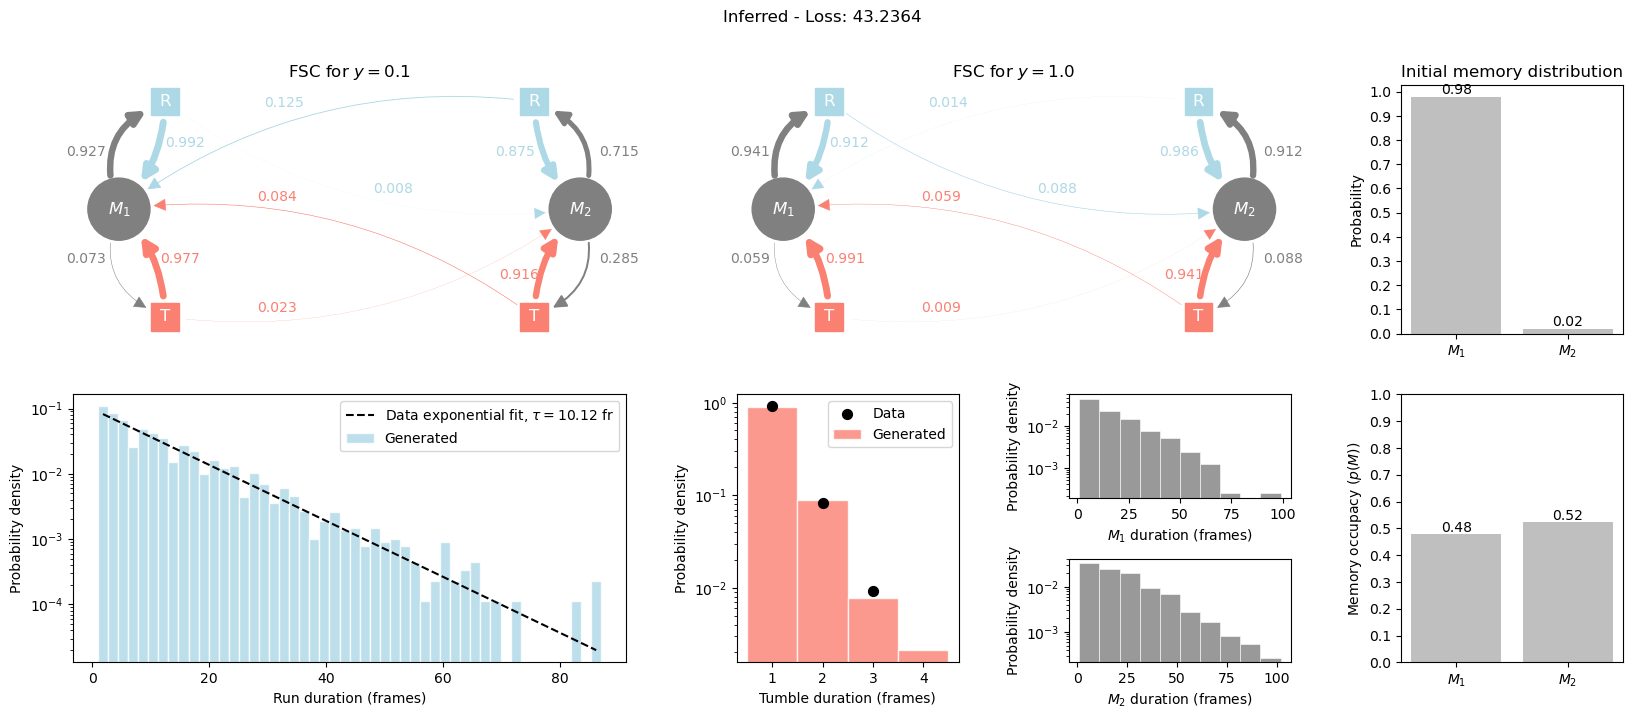

In [78]:
FSC_inferred.set_mode("generation")
res = FSC_inferred.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Inferred", return_results = True)

In [79]:
feature_array_all = np.array([np.ones(100), np.linspace(0, 1.5, 100)])

In [80]:
pActEq_designed, pMemEq_designed, policy_designed = FSC_designed.compute_eq_probability(feature_array_all)
pActEq_inferred, pMemEq_inferred, policy_inferred = FSC_inferred.compute_eq_probability(feature_array_all)

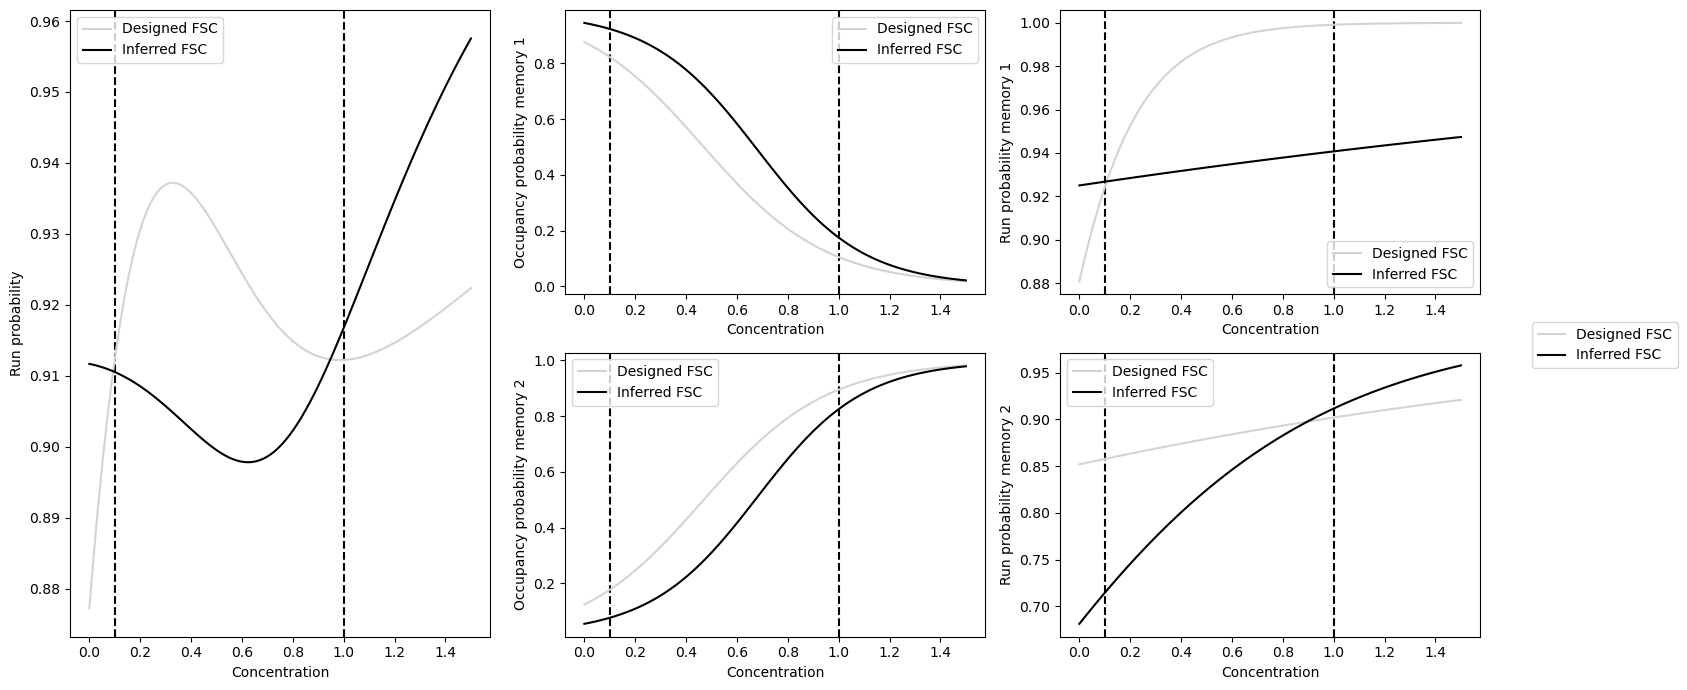

In [81]:
fig, axs = plt.subplot_mosaic([["run_prob", "pm1", "pi1"],
                               ["run_prob", "pm2", "pi2"]], figsize=(15, 7))

# Plot run probability
axs["run_prob"].plot(feature_array_all[1], pActEq_designed[:, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["run_prob"].plot(feature_array_all[1], pActEq_inferred[:, 0], label="Inferred FSC", c='black', alpha=1)
axs["run_prob"].set_xlabel("Concentration")
axs["run_prob"].set_ylabel("Run probability")
axs["run_prob"].legend()

# Plot pm1
axs["pm1"].plot(feature_array_all[1], pMemEq_designed[:, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pm1"].plot(feature_array_all[1], pMemEq_inferred[:, 0], label="Inferred FSC", c='black', alpha=1)
axs["pm1"].set_xlabel("Concentration")
axs["pm1"].set_ylabel("Occupancy probability memory 1")
axs["pm1"].legend()

# Plot pm2
axs["pm2"].plot(feature_array_all[1], pMemEq_designed[:, 1], label="Designed FSC", c='lightgrey', alpha=1)
axs["pm2"].plot(feature_array_all[1], pMemEq_inferred[:, 1], label="Inferred FSC", c='black', alpha=1)
axs["pm2"].set_xlabel("Concentration")
axs["pm2"].set_ylabel("Occupancy probability memory 2")
axs["pm2"].legend()

# Plot pi1
axs["pi1"].plot(feature_array_all[1], policy_designed[:, 0, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pi1"].plot(feature_array_all[1], policy_inferred[:, 0, 0], label="Inferred FSC", c='black', alpha=1)
axs["pi1"].set_xlabel("Concentration")
axs["pi1"].set_ylabel("Run probability memory 1")
axs["pi1"].legend()

# Plot pi2
axs["pi2"].plot(feature_array_all[1], policy_designed[:, 1, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pi2"].plot(feature_array_all[1], policy_inferred[:, 1, 0], label="Inferred FSC", c='black', alpha=1)
axs["pi2"].set_xlabel("Concentration")
axs["pi2"].set_ylabel("Run probability memory 2")
axs["pi2"].legend()

# Add a single legend on the right
handles, labels = axs["run_prob"].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)

for ax in axs.values():
    ax.axvline(0.1, c='k', ls='--', zorder=-1)
    ax.axvline(1, c='k', ls='--', zorder=-1)

plt.tight_layout()
plt.show()

In [82]:
generated_tr_inferred= FSC_inferred.generate_trajectories(features = features_play)

for i in range(len(generated_tr_inferred)):
    kkeys = list(generated_tr_inferred[i].keys())
    generated_tr_inferred[i]["actions"] = generated_tr_inferred[i]["actions"][NSteps1//2//tau_sub:]
    generated_tr_inferred[i]["memories"] = generated_tr_inferred[i]["memories"][NSteps1//2//tau_sub:]
    generated_tr_inferred[i]["features"] = generated_tr_inferred[i]["features"][:, NSteps1//2//tau_sub:]

In [83]:
actions_play = np.array([tr["actions"] for tr in generated_tr_inferred])
pr = np.mean(actions_play == 0, axis = 0)

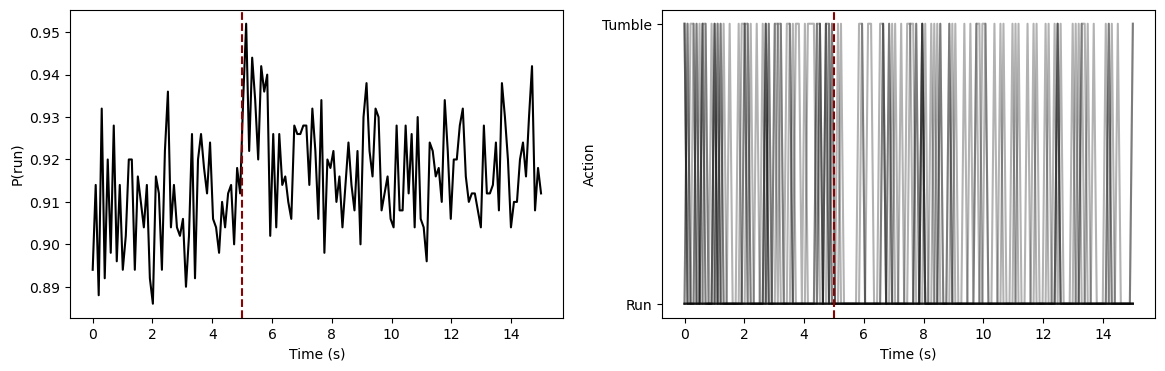

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(TimePlay, pr, c = 'k')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("P(run)")
axs[0].axvline(NSteps1//2*dt, c = 'darkred', ls = '--')

axs[1].plot(TimePlay, actions_play[:10].T, c = 'k', alpha = 0.3)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Action")
axs[1].set_yticks([0, 1], labels = ["Run", "Tumble"])
axs[1].axvline(NSteps1//2*dt, c = 'darkred', ls = '--')

plt.show()

# Train test

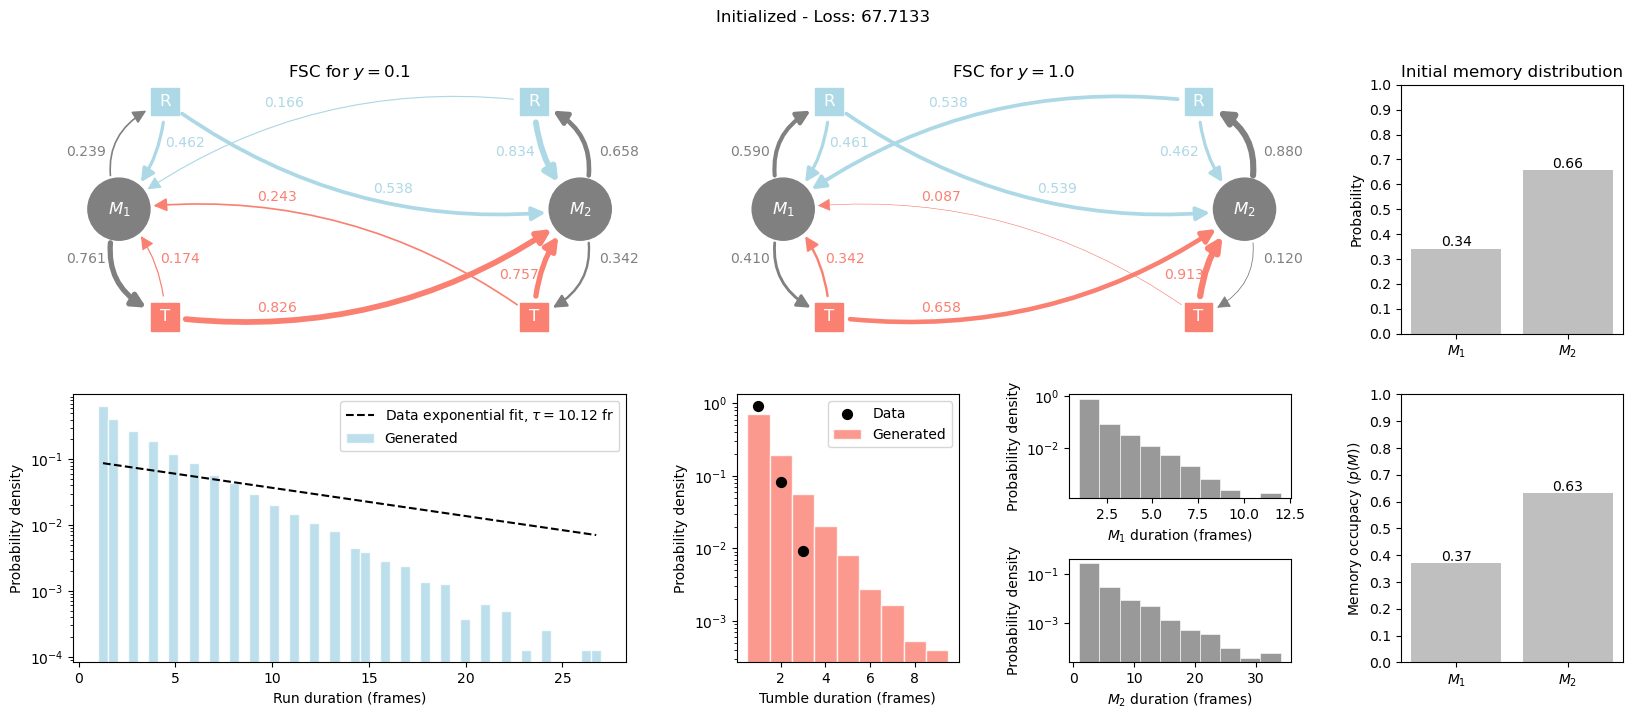

In [114]:
FSC_inferred = controller.FSC("continuous", M = M, A = A, F = F, mode = "generation", seed = 42)
FSC_inferred.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Initialized", return_results = False)

In [115]:
feature_array_all = np.array([np.ones(100), np.linspace(0, 1.5, 100)])

In [116]:
pActEq_designed, pMemEq_designed, policy_designed = FSC_designed.compute_eq_probability(feature_array_all)
pActEq_inferred, pMemEq_inferred, policy_inferred = FSC_inferred.compute_eq_probability(feature_array_all)

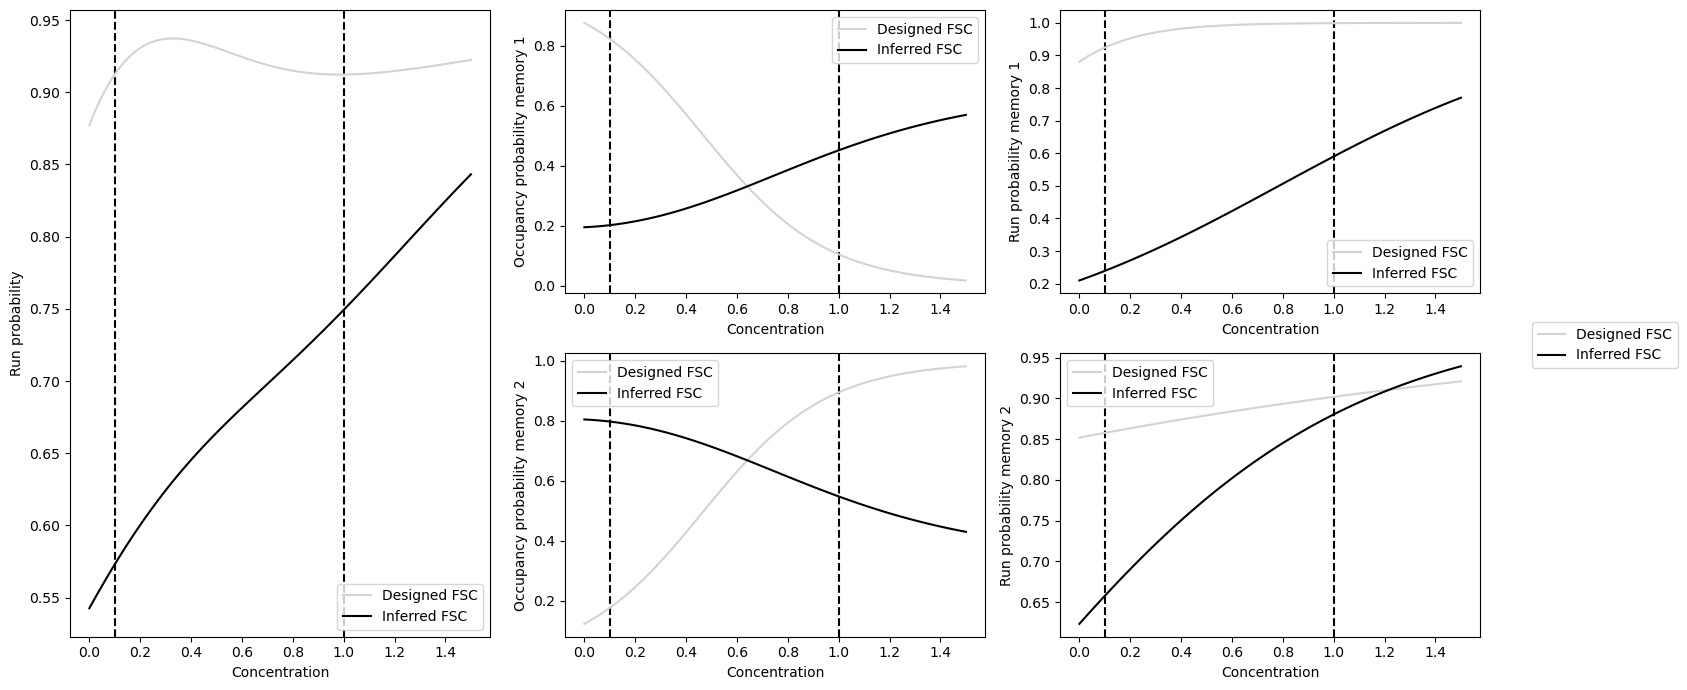

In [117]:
fig, axs = plt.subplot_mosaic([["run_prob", "pm1", "pi1"],
                               ["run_prob", "pm2", "pi2"]], figsize=(15, 7))

# Plot run probability
axs["run_prob"].plot(feature_array_all[1], pActEq_designed[:, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["run_prob"].plot(feature_array_all[1], pActEq_inferred[:, 0], label="Inferred FSC", c='black', alpha=1)
axs["run_prob"].set_xlabel("Concentration")
axs["run_prob"].set_ylabel("Run probability")
axs["run_prob"].legend()

# Plot pm1
axs["pm1"].plot(feature_array_all[1], pMemEq_designed[:, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pm1"].plot(feature_array_all[1], pMemEq_inferred[:, 0], label="Inferred FSC", c='black', alpha=1)
axs["pm1"].set_xlabel("Concentration")
axs["pm1"].set_ylabel("Occupancy probability memory 1")
axs["pm1"].legend()

# Plot pm2
axs["pm2"].plot(feature_array_all[1], pMemEq_designed[:, 1], label="Designed FSC", c='lightgrey', alpha=1)
axs["pm2"].plot(feature_array_all[1], pMemEq_inferred[:, 1], label="Inferred FSC", c='black', alpha=1)
axs["pm2"].set_xlabel("Concentration")
axs["pm2"].set_ylabel("Occupancy probability memory 2")
axs["pm2"].legend()

# Plot pi1
axs["pi1"].plot(feature_array_all[1], policy_designed[:, 0, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pi1"].plot(feature_array_all[1], policy_inferred[:, 0, 0], label="Inferred FSC", c='black', alpha=1)
axs["pi1"].set_xlabel("Concentration")
axs["pi1"].set_ylabel("Run probability memory 1")
axs["pi1"].legend()

# Plot pi2
axs["pi2"].plot(feature_array_all[1], policy_designed[:, 1, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pi2"].plot(feature_array_all[1], policy_inferred[:, 1, 0], label="Inferred FSC", c='black', alpha=1)
axs["pi2"].set_xlabel("Concentration")
axs["pi2"].set_ylabel("Run probability memory 2")
axs["pi2"].legend()

# Add a single legend on the right
handles, labels = axs["run_prob"].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)

for ax in axs.values():
    ax.axvline(0.1, c='k', ls='--', zorder=-1)
    ax.axvline(1, c='k', ls='--', zorder=-1)

plt.tight_layout()
plt.show()

In [118]:
%%time
tloss, vloss = FSC_inferred.fit(generated_tr,
                                NEpochs = 20,
                                NBatch = 25, lr = (0.01, 0.05, 0.05),
                                scheduler = "cyclic",
                                gamma = 0.99, train_split = 0.9)

Training with 450 trajectories and validating with 50 trajectories. Using a single learning rate of 0.01.
Epoch 1 - Training loss: 59.1044997829861, Validation loss: 51.76609809875488 - Learning rate: 0.01
Epoch 2 - Training loss: 47.192836642795136, Validation loss: 44.34517127990723 - Learning rate: 0.05500000000000001
Epoch 3 - Training loss: 43.918637966579865, Validation loss: 42.586175689697264 - Learning rate: 0.1
Epoch 4 - Training loss: 43.344554036458334, Validation loss: 42.53005298614502 - Learning rate: 0.05500000000000001
Epoch 5 - Training loss: 43.32840874565972, Validation loss: 42.52668170928955 - Learning rate: 0.01
Epoch 6 - Training loss: 43.31634290907119, Validation loss: 42.51911647796631 - Learning rate: 0.0325
Epoch 7 - Training loss: 43.33013576931423, Validation loss: 42.51180999755859 - Learning rate: 0.05500000000000001
Epoch 8 - Training loss: 43.32301757812499, Validation loss: 42.50958011627197 - Learning rate: 0.0325
Epoch 9 - Training loss: 43.3106441

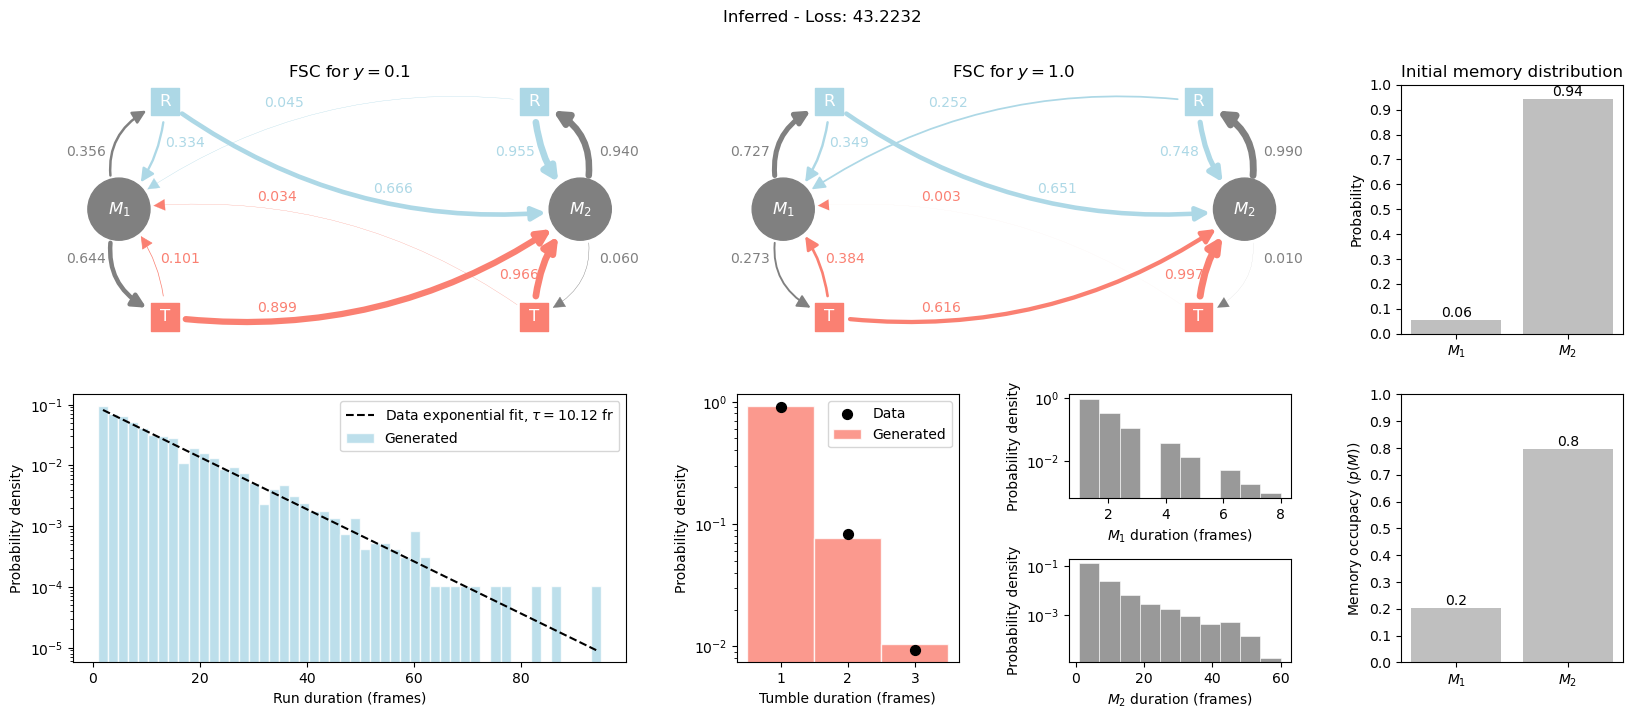

In [119]:
FSC_inferred.set_mode("generation")
res = FSC_inferred.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Inferred", return_results = True)

In [120]:
feature_array_all = np.array([np.ones(100), np.linspace(0, 1.5, 100)])

In [121]:
pActEq_designed, pMemEq_designed, policy_designed = FSC_designed.compute_eq_probability(feature_array_all)
pActEq_inferred, pMemEq_inferred, policy_inferred = FSC_inferred.compute_eq_probability(feature_array_all)

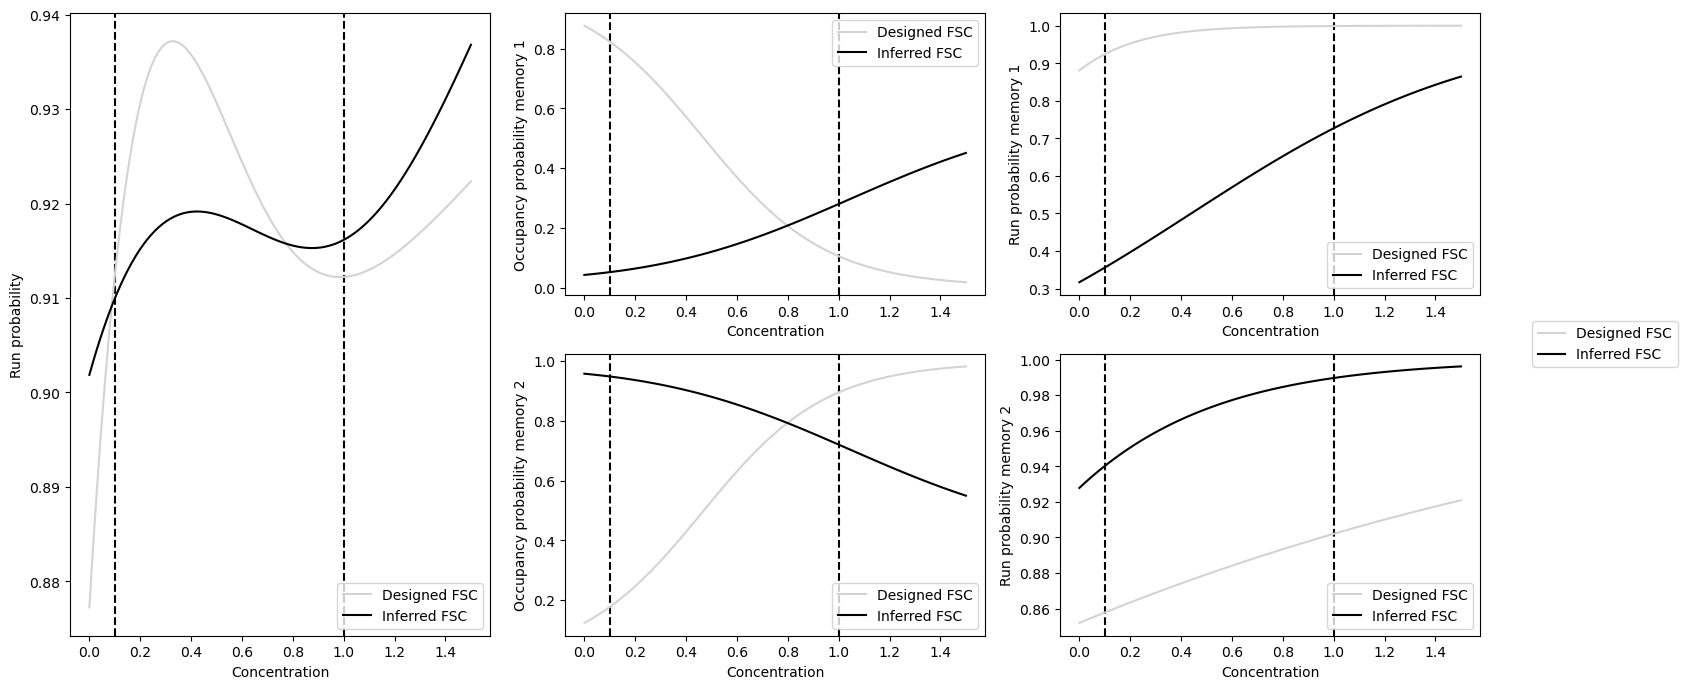

In [122]:
fig, axs = plt.subplot_mosaic([["run_prob", "pm1", "pi1"],
                               ["run_prob", "pm2", "pi2"]], figsize=(15, 7))

# Plot run probability
axs["run_prob"].plot(feature_array_all[1], pActEq_designed[:, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["run_prob"].plot(feature_array_all[1], pActEq_inferred[:, 0], label="Inferred FSC", c='black', alpha=1)
axs["run_prob"].set_xlabel("Concentration")
axs["run_prob"].set_ylabel("Run probability")
axs["run_prob"].legend()

# Plot pm1
axs["pm1"].plot(feature_array_all[1], pMemEq_designed[:, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pm1"].plot(feature_array_all[1], pMemEq_inferred[:, 0], label="Inferred FSC", c='black', alpha=1)
axs["pm1"].set_xlabel("Concentration")
axs["pm1"].set_ylabel("Occupancy probability memory 1")
axs["pm1"].legend()

# Plot pm2
axs["pm2"].plot(feature_array_all[1], pMemEq_designed[:, 1], label="Designed FSC", c='lightgrey', alpha=1)
axs["pm2"].plot(feature_array_all[1], pMemEq_inferred[:, 1], label="Inferred FSC", c='black', alpha=1)
axs["pm2"].set_xlabel("Concentration")
axs["pm2"].set_ylabel("Occupancy probability memory 2")
axs["pm2"].legend()

# Plot pi1
axs["pi1"].plot(feature_array_all[1], policy_designed[:, 0, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pi1"].plot(feature_array_all[1], policy_inferred[:, 0, 0], label="Inferred FSC", c='black', alpha=1)
axs["pi1"].set_xlabel("Concentration")
axs["pi1"].set_ylabel("Run probability memory 1")
axs["pi1"].legend()

# Plot pi2
axs["pi2"].plot(feature_array_all[1], policy_designed[:, 1, 0], label="Designed FSC", c='lightgrey', alpha=1)
axs["pi2"].plot(feature_array_all[1], policy_inferred[:, 1, 0], label="Inferred FSC", c='black', alpha=1)
axs["pi2"].set_xlabel("Concentration")
axs["pi2"].set_ylabel("Run probability memory 2")
axs["pi2"].legend()

# Add a single legend on the right
handles, labels = axs["run_prob"].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)

for ax in axs.values():
    ax.axvline(0.1, c='k', ls='--', zorder=-1)
    ax.axvline(1, c='k', ls='--', zorder=-1)

plt.tight_layout()
plt.show()

In [123]:
generated_tr_inferred= FSC_inferred.generate_trajectories(features = features_play)

for i in range(len(generated_tr_inferred)):
    kkeys = list(generated_tr_inferred[i].keys())
    generated_tr_inferred[i]["actions"] = generated_tr_inferred[i]["actions"][NSteps1//2//tau_sub:]
    generated_tr_inferred[i]["memories"] = generated_tr_inferred[i]["memories"][NSteps1//2//tau_sub:]
    generated_tr_inferred[i]["features"] = generated_tr_inferred[i]["features"][:, NSteps1//2//tau_sub:]

In [124]:
actions_play = np.array([tr["actions"] for tr in generated_tr_inferred])
pr = np.mean(actions_play == 0, axis = 0)

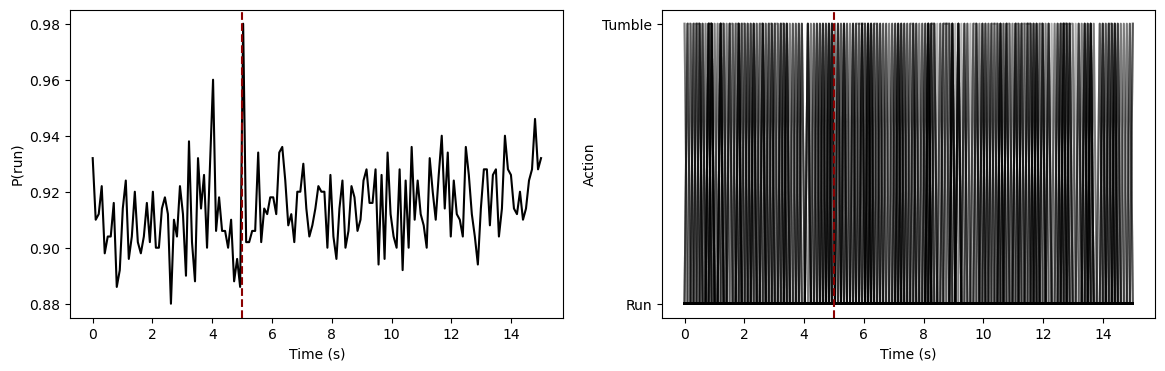

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(TimePlay, pr, c = 'k')
axs[0].axvline(NSteps1//2*dt, c = 'darkred', ls = '--')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("P(run)")

axs[1].plot(TimePlay, actions_play[:50].T, c = 'k', alpha = 0.3)
axs[1].axvline(NSteps1//2*dt, c = 'darkred', ls = '--')

axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Action")
axs[1].set_yticks([0, 1], labels = ["Run", "Tumble"])

plt.show()